# Calculate `Anomalous Token Transfers Detection Machine Learning Bot`'s Stats with Forta API


* [bot README](https://github.com/forta-network/starter-kits/tree/main/anomalous-token-transfers-ml-py/README.md)
* [bot details page](https://explorer.forta.network/bot/0x2e51c6a89c2dccc16a813bb0c3bf3bbfe94414b6a0ea3fc650ad2a59e148f3c8)

In [2]:
from datetime import datetime, timedelta

import pandas as pd
import requests

# 1. Query previous day's bot alerts with the Forta API

In [49]:
forta_api = "https://api.forta.network/graphql"
headers = {"content-type": "application/json"}

# start and end date needs to be in the format: YYYY-MM-DD
START_DATE = str((datetime.today() - timedelta(days=1)).date())
END_DATE = START_DATE
BOT_ID = "0x2e51c6a89c2dccc16a813bb0c3bf3bbfe94414b6a0ea3fc650ad2a59e148f3c8"

query = """
query exampleQuery($input: AlertsInput) {
  alerts(input: $input) {
    alerts {
      findingType
      severity
      metadata
      alertId
      hash
      source {
        block {
          number
        }
        transactionHash
      }
    }
    pageInfo {
      hasNextPage
      endCursor {
        blockNumber
        alertId
      }
    }
  }
}
"""

query_variables = {
  "input": {
    "first": 9999,
    "bots": [BOT_ID],
    "blockDateRange": {
      "startDate": START_DATE,
      "endDate": END_DATE
    }
  }
}

In [50]:
all_alerts = []
next_page_exists = True

while next_page_exists:
    # query Forta API
    payload = dict(query=query, variables=query_variables)
    response = requests.request("POST", forta_api, json=payload, headers=headers)

    # collect alerts
    data = response.json()['data']['alerts']
    alerts = data['alerts']
    all_alerts += alerts

    # get next page of alerts if it exists
    next_page_exists = data['pageInfo']['hasNextPage']
    # endCursor contains alert Id and block number.
    # This is needed to get the next page of alerts.
    end_cursor = data['pageInfo']['endCursor']
    query_variables['input']['after'] = end_cursor

In [51]:
df = pd.json_normalize(all_alerts)

In [52]:
df.to_csv(f'{START_DATE}_alerts.csv', index=None)

In [61]:
# remove duplicate alerts for each transaction
df = df.drop_duplicates('source.transactionHash')

In [62]:
df.head(5)

,findingType,severity,alertId,hash,metadata.ikolfTransfers,metadata.ikolfValue,metadata.wethTransfers,metadata.wethValue,metadata.accountAgeInMinutes,metadata.anomalyScore,...,metadata.copingTransfers,metadata.copingValue,metadata.asanTransfers,metadata.asanValue,metadata.🐱Transfers,metadata.🐱Value,metadata.cashnipTransfers,metadata.cashnipValue,metadata.ctznTransfers,metadata.ctznValue
0,INFORMATION,INFO,NORMAL-TOKEN-TRANSFERS-TX,0xf55c12e82132659ac0105facfc72c19f55b84065cfb0dc960f1bf986f331d79c,2,1422.725,2,0.197,812337.0833333334,0.313,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,INFORMATION,INFO,NORMAL-TOKEN-TRANSFERS-TX,0xed033b70db11cbd05169cb32463b728d4f849415ea07719521d066b6b83b4c3d,NaN,NaN,NaN,NaN,1769047.6833333333,0.314,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,INFORMATION,INFO,NORMAL-TOKEN-TRANSFERS-TX,0xde8daaafd40b9078393f040877b551d2b57be609f8aa0411a02443426e5871d8,NaN,NaN,1,0.507,287494.81666666665,0.305,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,INFORMATION,INFO,NORMAL-TOKEN-TRANSFERS-TX,0xdd55f9153faf5daab3393aefa0a8e0af8c782b59728272b93ea1d9941c4c67cf,NaN,NaN,NaN,NaN,1769047.6833333333,0.328,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,INFORMATION,INFO,NORMAL-TOKEN-TRANSFERS-TX,0xdd1baf31b7fe485891811f7c60c22e02af46abaac885b9b24a89496eafb1035f,NaN,NaN,NaN,NaN,1172160.1333333333,0.317,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 2. Gather Stats

## Severity Level Breakdown Percentage

In [63]:
TOTAL_ALERTS = len(df)

severity_level = df.groupby(['severity', 'alertId']).agg({'hash': 'count'}).reset_index().rename(columns={'hash': 'hash_count'})
severity_level['percentage'] = (severity_level['hash_count'] / TOTAL_ALERTS) * 100

In [64]:
severity_level

,severity,alertId,hash_count,percentage
0,CRITICAL,ANOMALOUS-TOKEN-TRANSFERS-TX,589,0.371365
1,INFO,NORMAL-TOKEN-TRANSFERS-TX,157763,99.469749
2,LOW,INVALID-TOKEN-TRANSFERS-TX,252,0.158886


**Anomaly Rate** = `0.3714%`

**Model Input Generation Issues** = `0.1589%`

## Alert Time Series by Severity

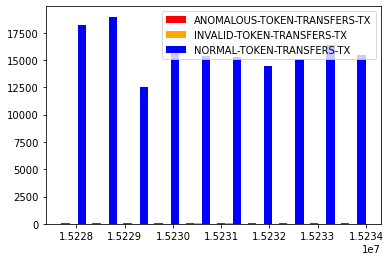

In [65]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')

anomalous_alerts = df[df['severity'] == 'CRITICAL']['source.block.number']
model_input_issue_alerts = df[df['severity'] == 'LOW']['source.block.number']
normal_tx_alerts = df[df['severity'] == 'INFO']['source.block.number']

plt.hist([anomalous_alerts, model_input_issue_alerts, normal_tx_alerts],
         label=['ANOMALOUS-TOKEN-TRANSFERS-TX', 'INVALID-TOKEN-TRANSFERS-TX', 'NORMAL-TOKEN-TRANSFERS-TX'],
         color=['red', 'orange', 'blue'])
plt.legend(loc='upper right')
plt.show()

## Anomaly Rate Deviation Between Training and Production

In [66]:
TRAINING_ANOMALY_RATE = 0.387
PRODUCTION_ANOMALY_RATE = severity_level[severity_level['alertId'] == 'ANOMALOUS-TOKEN-TRANSFERS-TX']['percentage'].values[0]

deviation = ((PRODUCTION_ANOMALY_RATE - TRAINING_ANOMALY_RATE) / TRAINING_ANOMALY_RATE) * 100.0
print(f"There's a {deviation}% deviation of anomaly rate from training to production")

There's a -4.040010069770901% deviation of anomaly rate from training to production


## Anomaly Score Distribution

The above deviation can be reduced by tweaking the model's `ANOMALY_THRESHOLD`. 

In [67]:
df['metadata.anomalyScore'] = df['metadata.anomalyScore'].astype(float)
anomalies = df[df['alertId'] == 'ANOMALOUS-TOKEN-TRANSFERS-TX']

<AxesSubplot:>

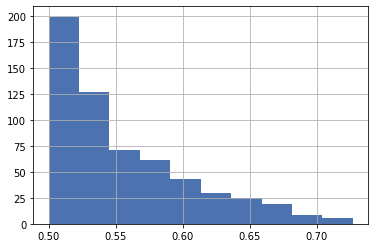

In [68]:
anomalies['metadata.anomalyScore'].hist()

In [75]:
# increasing the threshold = lower anomaly rate
# decreasing the threshold = higher anomaly rate
NEW_ANOMALY_THRESHOLD = 0.499
new_anomaly_count = (df['metadata.anomalyScore'] >= NEW_ANOMALY_THRESHOLD).value_counts()[1]
new_anomaly_rate = (new_anomaly_count / TOTAL_ALERTS) * 100

print(f"An `ANOMALY_THRESHOLD` set to {NEW_ANOMALY_THRESHOLD} can adjust the production anomaly rate to {new_anomaly_rate}%.")

An `ANOMALY_THRESHOLD` set to 0.499 can adjust the production anomaly rate to 0.3814531789866586%.


If this new anomaly threshold is preferred, don't forget to update it in the detection bot and re-deploy the bot. 

## Top 5 transactions with the highest anomaly score

In [70]:
pd.set_option('max_colwidth', None)

In [71]:
anomalies.sort_values('metadata.anomalyScore', ascending=False)[['source.transactionHash', 'metadata.anomalyScore']].head(5)

,source.transactionHash,metadata.anomalyScore
21484,0x6b1e11fdbb209b3af30fbc4f2e474566a89bc5cda12948291907640ce028c202,0.727
17779,0x1bfdbf1ca12fff416b205a4c4be25612b38e70855471c824b9c228fc3fa9351a,0.722
56194,0x88c9738e5eefc9912b4bc43fab4cdff1e2da862c799a417968952079d76366e4,0.720
98421,0x4025c8b6c6975be1932428866dc3e352446cddaf4c23a864b0607e21a790af6e,0.716
47548,0x75b83ba93d1331fc01751ff5cf7d595e85a8a906bfc9797928d3af762f543840,0.712


Transaction `0x6b1e11fdbb209b3af30fbc4f2e474566a89bc5cda12948291907640ce028c202` on Etherscan: [link](https://etherscan.io/tx/0x6b1e11fdbb209b3af30fbc4f2e474566a89bc5cda12948291907640ce028c202)